# License Funding Modeling 

## 0. Import required packages and load dataset 

In [1]:
# general packages
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pprint import pprint
import warnings
#warnings.filterwarnings("ignore")
import pickle

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix,classification_report
from xgboost import XGBClassifier

# imbelearn package
from imblearn.over_sampling import SMOTE

## 1. Read data

In [2]:
df = pd.read_csv('modeling_license_2012.csv', sep = ',')

# print first few rows of df 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 41 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Unnamed: 0                                        1192 non-null   int64  
 1   Disclosure_Date                                   1192 non-null   float64
 2   Country_WIPO_ID                                   1192 non-null   float64
 3   Actually_File_Date                                1192 non-null   float64
 4   Is_Priority                                       1192 non-null   float64
 5   Lawfirm                                           1192 non-null   float64
 6   Attorney                                          1192 non-null   float64
 7   Number_of_Inventors                               1192 non-null   float64
 8   Application_Type                                  1192 non-null   float64
 9   Lead_Inventor      

## 2. Model Preprocessing

In [3]:
# drop unamed column 
df = df.drop(df.columns[0], axis=1)

# Remove row with null patent_status
df = df.dropna(subset=['License_Status'])

# convert funding status to binary 
df.loc[df['License_Status']=='no_license', 'License_Status'] = 0
df.loc[df['License_Status']=='license', 'License_Status'] = 1
df["License_Status"] = df.License_Status.astype(float)

df.head()

,Disclosure_Date,Country_WIPO_ID,Actually_File_Date,Is_Priority,Lawfirm,Attorney,Number_of_Inventors,Application_Type,Lead_Inventor,Division_Department,...,topic1,topic2,topic3,lda_topic,Licenses_in_Division,Successful Licenses_in_Division,Division_License_Success_Rate,Licenses_in_Tech,Disclosure_to_Filing,License_Status
0,0.620401,0.941176,0.041535,1.0,0.647059,0.784314,0.2,0.571429,0.887640,0.645161,...,0.034306,0.427883,0.550959,1.0,1.0,1.0,0.0,0.0,0.162785,1.0
1,0.725569,0.941176,0.199264,1.0,0.490196,0.509804,0.2,0.571429,0.331461,0.440860,...,0.032536,0.038858,0.950607,1.0,1.0,1.0,0.0,0.0,0.104683,1.0
2,0.800943,0.941176,0.422450,1.0,0.156863,0.843137,0.2,0.571429,0.926966,0.268817,...,0.736320,0.176054,0.108932,0.0,1.0,1.0,0.0,0.0,0.115452,0.0
3,0.700081,0.941176,0.153785,1.0,0.647059,0.784314,0.4,0.571429,0.853933,0.075269,...,0.178352,0.108110,0.734465,1.0,1.0,1.0,0.0,0.0,0.115327,0.0
4,0.866637,0.941176,0.640641,0.5,0.490196,0.509804,0.5,0.571429,0.331461,0.440860,...,0.205410,0.393692,0.415415,1.0,1.0,1.0,0.0,0.0,0.136113,1.0


In [4]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Keeping the highly correlated features attains higher model scoring, so we will keep
to_drop

# # Drop features 
#df.drop(to_drop, axis=1, inplace=True)

/var/folders/34/jx7syzxj4gb7wqhvvcjq6rgr0000gn/T/ipykernel_84346/3739957888.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['Licenses_in_Division', 'Successful Licenses_in_Division']

In [5]:
X = df.iloc[:, 0:39]
y = df.iloc[:, 39]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# check split of data
len(x_train), len(y_train), len(x_test), len(y_test), len(df)

(953, 953, 239, 239, 1192)

In [6]:
# Employment of SMOTE to oversample skewed funding outputs. This yields better results 
sm = SMOTE()
x_train, y_train = sm.fit_resample(x_train, y_train)

# check shape of x_train and y_train, and new response variable ratio
print(x_train.shape)
print(y_train.shape)
print(y_train.value_counts(normalize = True))

(1488, 39)
(1488,)
1.0    0.5
0.0    0.5
Name: License_Status, dtype: float64


## 3. Binary Classification Modeling Pipeline


### Ensemble learning models perform better than standard binary classification models
In this section, we train a number of models using the default model setting and compare their performance using f1 score. We will select the top 3 models to further explore in the next section.

In [7]:
pipelines = []
# Standard binary classification models 
pipelines.append(('LogisticRegression', Pipeline([('LR',linear_model.LogisticRegression())])))
pipelines.append(('KNearestNeighbors', Pipeline([('KNN',KNeighborsClassifier())])))
pipelines.append(('LinearSVC', Pipeline([('SVC',LinearSVC())])))
pipelines.append(('DecisionTree', Pipeline([('DTREE',DecisionTreeClassifier())])))
# Employment of ensemble learning 
pipelines.append(('BaggingClassifier', Pipeline([('BAG',BaggingClassifier())])))
pipelines.append(('BoostClassifier', Pipeline([('BOOST',AdaBoostClassifier())])))
pipelines.append(('RandomForest', Pipeline([('FOREST',RandomForestClassifier())])))
pipelines.append(('GradientBoost', Pipeline([('GBoost',GradientBoostingClassifier())])))
pipelines.append(('XGBoosting', Pipeline([('XGBoost',XGBClassifier(objective='binary:logistic', eval_metric='error'))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression: 0.800465 (0.026458)
KNearestNeighbors: 0.882472 (0.023332)
LinearSVC: 0.813596 (0.023017)
DecisionTree: 0.914130 (0.032799)
BaggingClassifier: 0.927885 (0.016832)
BoostClassifier: 0.898580 (0.010906)
RandomForest: 0.953400 (0.012456)
GradientBoost: 0.939994 (0.015683)
XGBoosting: 0.964824 (0.012618)


### Models with top f1 score:
1. RandomForest
2. XGBoost
3. GradientBoost

## 4. Model Outputs for selected models

In this section, we double tap into the 6 models with top f1 scores. We read their confusion matrix to make sure the Type I and Type II errors are not too high. We also predict the trianing, testing and CV datasets using each model to compile a table where we can compare results from each round. The goal is to see how much a gap there is for each model between training and testing results and between trianing and CV results to avoid overfitting problem.

In [8]:
def roc_curve(model):
    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [9]:
def fitting_score(train_predictions, test_predictions, model):
    # Evaluate the train, test and CV metrics
    # train
    train_recall = metrics.recall_score(y_train, train_predictions, average='macro')
    train_precision = metrics.precision_score(y_train, train_predictions, average='macro')
    train_f1 = metrics.f1_score(y_train, train_predictions, average='macro')

    # test
    test_recall = metrics.recall_score(y_test, test_predictions, average='macro')
    test_precision = metrics.precision_score(y_test, test_predictions, average='macro')
    test_f1 = metrics.f1_score(y_test, test_predictions, average='macro')

    # CV
    cv_recall = cross_val_score(model, x_train, y_train, cv=5, scoring='recall', n_jobs=-1).mean()
    cv_precision = cross_val_score(model, x_train, y_train, cv=5, scoring='precision', n_jobs=-1).mean()
    cv_f1 = cross_val_score(model, x_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    # Put everything in a table
    d = {'train': [train_recall, train_precision, train_f1], 'test': [test_recall, test_precision, test_f1],
        'cv':[cv_recall, cv_precision, cv_f1]}
    score_df = pd.DataFrame(data=d, index=['recall', 'precision', 'f1'])
    return score_df.round(decimals=3)

### 4.1. Random Forest 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


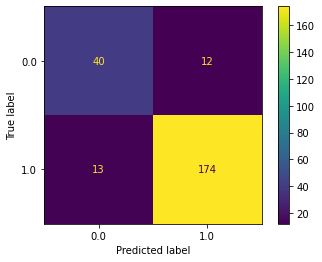


Random Forest Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.75      0.77      0.76        52
         1.0       0.94      0.93      0.93       187

    accuracy                           0.90       239
   macro avg       0.85      0.85      0.85       239
weighted avg       0.90      0.90      0.90       239


Accuracy: 0.895

 Random Forest Train/Test/CV Scoring


,train,test,cv
recall,1.0,0.850,0.930
precision,1.0,0.845,0.975
f1,1.0,0.847,0.951


In [10]:
#Produce and save the model, then load and apply the model.
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train, y_train)
rfc_predictions = rfc.predict(x_test)
rfc_predictions_train=rfc.predict(x_train)

rfc_matrix = metrics.confusion_matrix(y_test,rfc_predictions)

plot_confusion_matrix(rfc, x_test, y_test)  
plt.show()

class_report_rfc = classification_report(y_test, rfc_predictions)
print("\nRandom Forest Confusion Matrix\n",class_report_rfc)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,rfc_predictions),3))


print('\n Random Forest Train/Test/CV Scoring')
fitting_score(rfc_predictions_train, rfc_predictions, rfc)

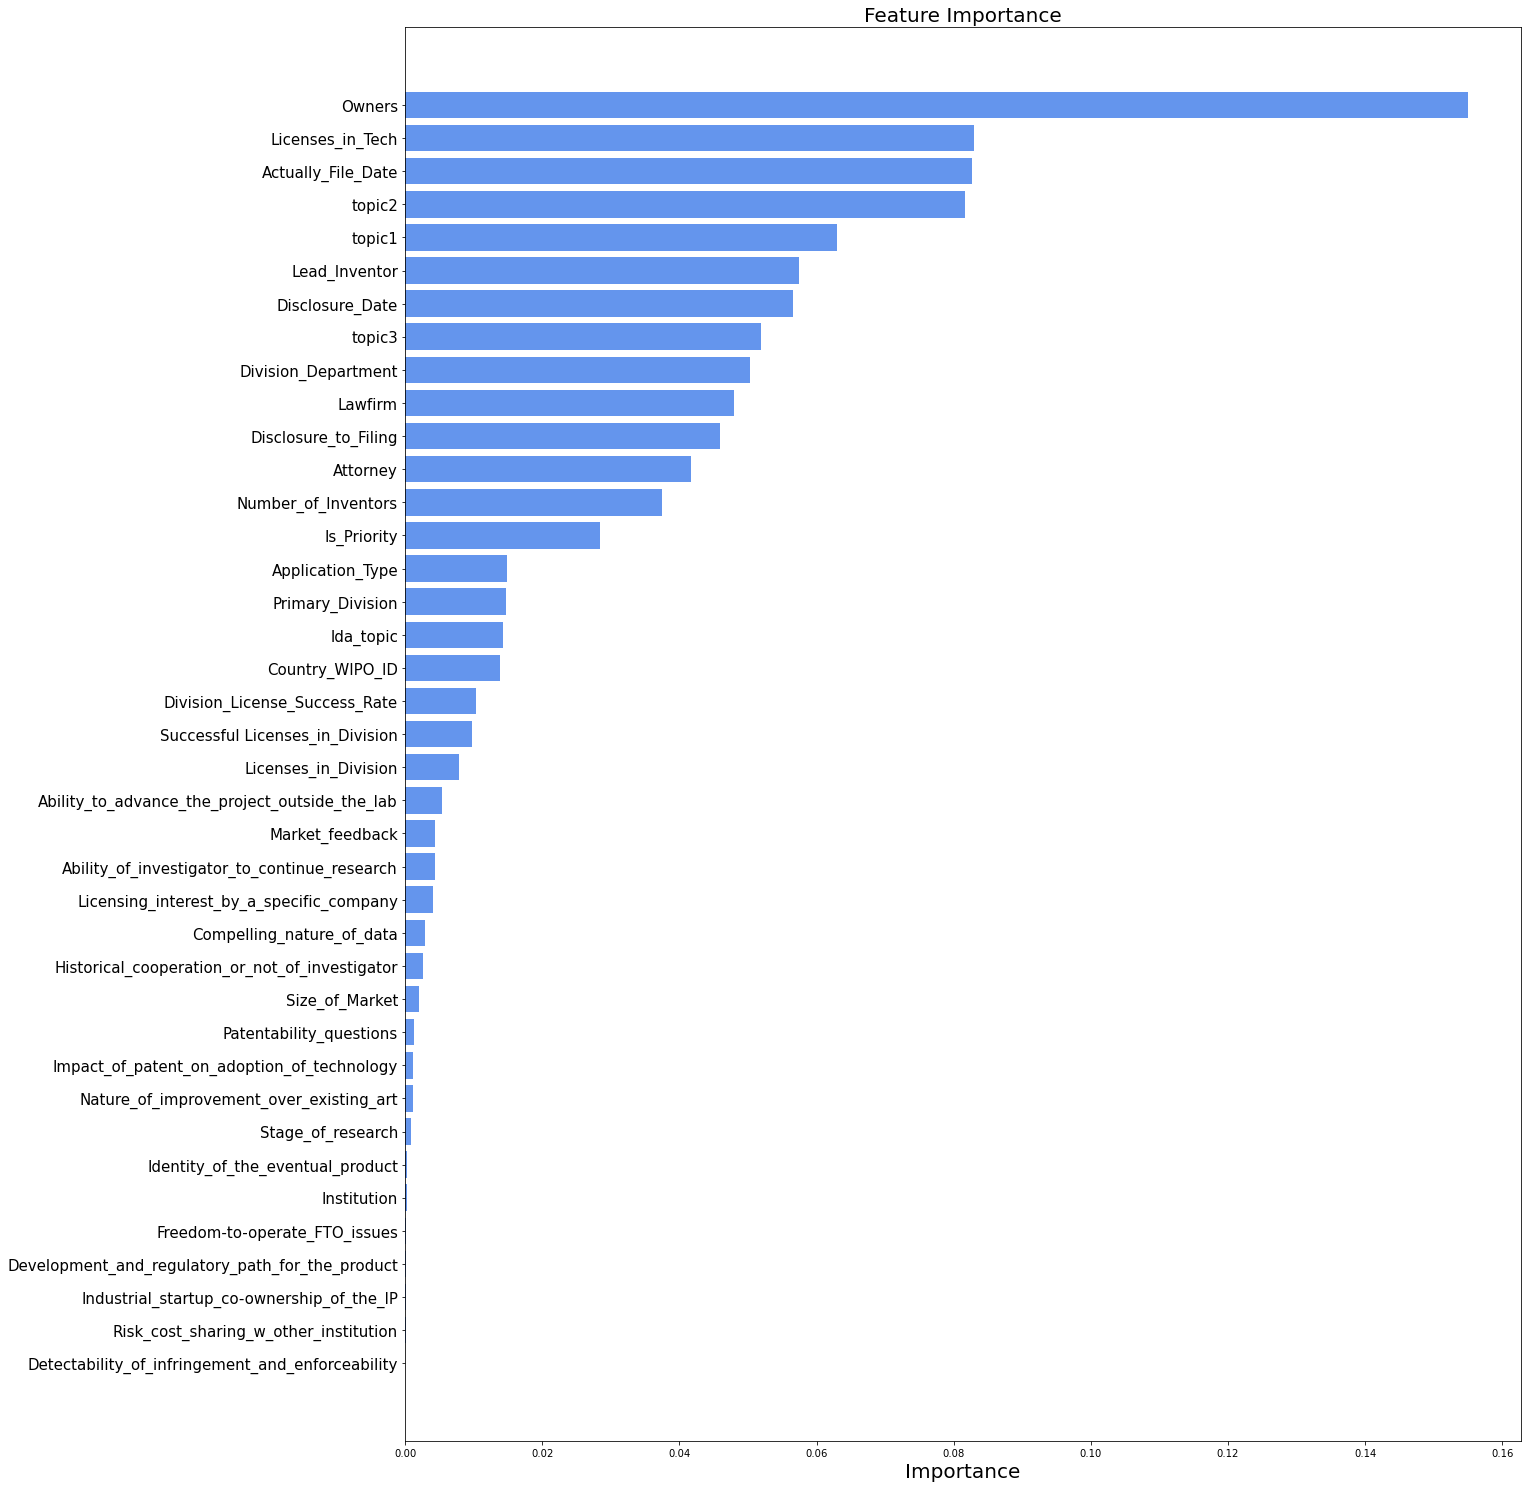

In [11]:
# Review feature importance in descending order
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 26))
plt.title('Feature Importance', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='cornflowerblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=15)
plt.xlabel('Importance', fontsize=20)
plt.show()

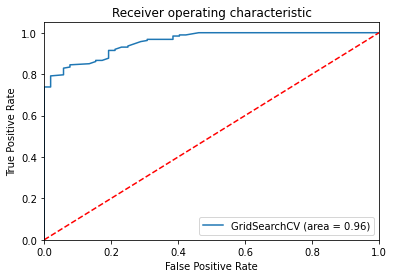

In [12]:
roc_curve(rfc)

### 4.2 XGBoost 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


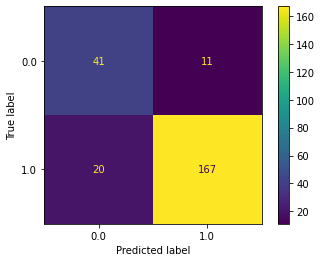


Gradient Boosting Classifier Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.67      0.79      0.73        52
         1.0       0.94      0.89      0.92       187

    accuracy                           0.87       239
   macro avg       0.81      0.84      0.82       239
weighted avg       0.88      0.87      0.87       239


Accuracy: 0.87

 Gradient Boosting Classification Train/Test/CV Scoring


,train,test,cv
recall,0.962,0.841,0.915
precision,0.962,0.805,0.936
f1,0.962,0.820,0.924


In [13]:
#Produce and save the model, then load and apply the model.
# Initial estimations for XGBoost were included within the model 
xgb = XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='error', gamma=10,
                   colsample_bytree=0.25, learning_rate=0.1, n_estimators=200, reg_lambda=1)
xgb.fit(x_train, y_train)
xgb_predictions = xgb.predict(x_test)
xgb_predictions_train = xgb.predict(x_train)

xgb_matrix = metrics.confusion_matrix(y_test,xgb_predictions)

plot_confusion_matrix(xgb, x_test, y_test)  
plt.show()

class_report_xgb = classification_report(y_test, xgb_predictions)
print("\nXGBoost Confusion Matrix\n",class_report_xgb)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,xgb_predictions),3))

print('\nXGBoost Train/Test/CV Scoring')
fitting_score(xgb_predictions_train, xgb_predictions, xgb)

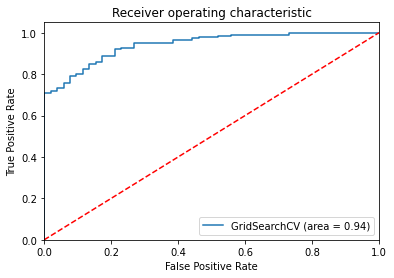

In [14]:
roc_curve(xgb)

### 4.3. Gradient Boosting 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


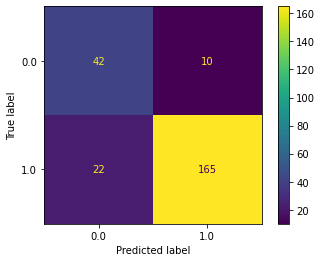


Gradient Boosting Classifier Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.66      0.81      0.72        52
         1.0       0.94      0.88      0.91       187

    accuracy                           0.87       239
   macro avg       0.80      0.85      0.82       239
weighted avg       0.88      0.87      0.87       239


Accuracy: 0.866

 Gradient Boosting Classification Train/Test/CV Scoring


,train,test,cv
recall,0.981,0.845,0.919
precision,0.982,0.800,0.953
f1,0.981,0.818,0.935


In [15]:
#Produce and save the model, then load and apply the model.
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(x_train, y_train)
gbm_predictions = gbm.predict(x_test)
gbm_predictions_train = gbm.predict(x_train)

gbm_matrix = metrics.confusion_matrix(y_test,gbm_predictions)

plot_confusion_matrix(gbm, x_test, y_test)  
plt.show()

class_report_gbm = classification_report(y_test, gbm_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",class_report_gbm)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,gbm_predictions),3))

print('\n Gradient Boosting Classification Train/Test/CV Scoring')
fitting_score(gbm_predictions_train, gbm_predictions, gbm)

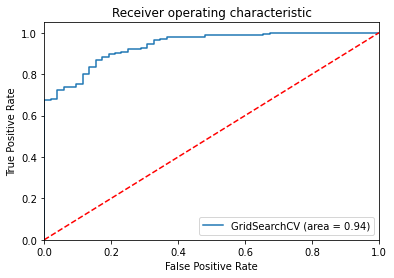

In [16]:
roc_curve(gbm)

## 5. Hyperparameter Tuning
In this section, we further select the top 3 models to perform hyperparameter tuning. We are uisng grid search to look for the best combination of different model parameter settings. We also perform additional manual tuning on the parameters if there is significant overfitting.

### 5.1. Parameter Tuning for Random Forest (best f1 test scoring, but overfitting occurring)

In [17]:
# Tune learning rate and n_estimators
tuned_param = {'n_estimators':[100, 300, 500, 800, 1200], 'min_samples_split':[2, 5, 10, 15, 100], 
               'min_samples_leaf':[1, 2, 5, 10], 'max_depth':[5, 8, 15, 25, 30]}
tuning = GridSearchCV(estimator =rfc, 
                      param_grid = tuned_param, scoring='f1',n_jobs=4, cv=3, verbose = 1)
tuning.fit(x_train,y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid={'max_depth': [5, 8, 15, 25, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [100, 300, 500, 800, 1200]},
             scoring='f1', verbose=1)

In [18]:
tuning.best_params_

{'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1200}

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


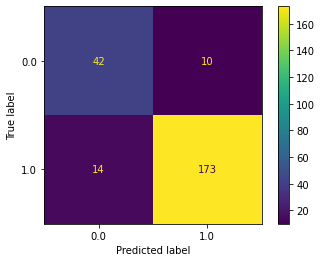


Random Forest Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.75      0.81      0.78        52
         1.0       0.95      0.93      0.94       187

    accuracy                           0.90       239
   macro avg       0.85      0.87      0.86       239
weighted avg       0.90      0.90      0.90       239


Accuracy: 0.9

 Random Forest Train/Test/CV Scoring


,train,test,cv
recall,1.0,0.866,0.935
precision,1.0,0.848,0.972
f1,1.0,0.856,0.953


In [28]:
#Produce and save the model, then load and apply the model.
rfc = RandomForestClassifier(max_depth=25, min_samples_leaf=1,
                            min_samples_split=5, n_estimators=1200, random_state=42)
rfc.fit(x_train, y_train)
rfc_predictions = rfc.predict(x_test)
rfc_predictions_train=rfc.predict(x_train)

rfc_matrix = metrics.confusion_matrix(y_test,rfc_predictions)

plot_confusion_matrix(rfc, x_test, y_test)  
plt.show()

class_report_rfc = classification_report(y_test, rfc_predictions)
print("\nRandom Forest Confusion Matrix\n",class_report_rfc)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,rfc_predictions),3))


print('\n Random Forest Train/Test/CV Scoring')
fitting_score(rfc_predictions_train, rfc_predictions, rfc)

We observe significant overfitting, so we need to manually tune the model parameters again

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


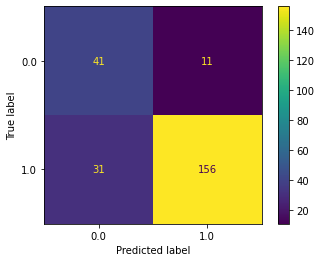


Random Forest Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.57      0.79      0.66        52
         1.0       0.93      0.83      0.88       187

    accuracy                           0.82       239
   macro avg       0.75      0.81      0.77       239
weighted avg       0.85      0.82      0.83       239


Accuracy: 0.824

 Random Forest Train/Test/CV Scoring


,train,test,cv
recall,0.929,0.811,0.883
precision,0.930,0.752,0.925
f1,0.929,0.771,0.903


In [30]:
#Produce and save the model, then load and apply the model.
rfc = RandomForestClassifier(max_depth=5, min_samples_leaf=1,
                            min_samples_split=5, n_estimators=1200, random_state=42)
rfc.fit(x_train, y_train)
rfc_predictions = rfc.predict(x_test)
rfc_predictions_train=rfc.predict(x_train)

rfc_matrix = metrics.confusion_matrix(y_test,rfc_predictions)

plot_confusion_matrix(rfc, x_test, y_test)  
plt.show()

class_report_rfc = classification_report(y_test, rfc_predictions)
print("\nRandom Forest Confusion Matrix\n",class_report_rfc)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,rfc_predictions),3))


print('\n Random Forest Train/Test/CV Scoring')
fitting_score(rfc_predictions_train, rfc_predictions, rfc)

### 5.1. Parameter Tuning for Gradient Boosting (Good f1 scoring and less overfitting)

In [20]:
# Tune learning rate and n_estimators
tuned_param = {'learning_rate':[0.1,0.05,0.01], 'n_estimators':[100,250,500], 'min_samples_split':[2,20,50], 
               'min_samples_leaf':[1, 10, 20]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, random_state=2, 
                               subsample=1), 
                      param_grid = tuned_param, scoring='f1',n_jobs=4, cv=5)
tuning.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4, random_state=2,
                                                  subsample=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'min_samples_leaf': [1, 10, 20],
                         'min_samples_split': [2, 20, 50],
                         'n_estimators': [100, 250, 500]},
             scoring='f1')

In [21]:
tuning.best_params_, (-tuning.best_score_)**(1/2)

/var/folders/34/jx7syzxj4gb7wqhvvcjq6rgr0000gn/T/ipykernel_84346/2117021311.py:1: RuntimeWarning: invalid value encountered in double_scalars
  tuning.best_params_, (-tuning.best_score_)**(1/2)


({'learning_rate': 0.1,
  'min_samples_leaf': 20,
  'min_samples_split': 50,
  'n_estimators': 500},
 nan)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


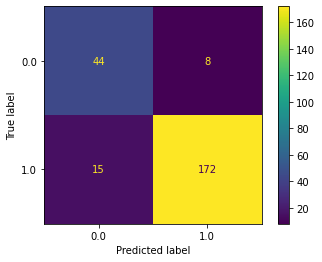


Gradient Boosting Classifier Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.75      0.85      0.79        52
         1.0       0.96      0.92      0.94       187

    accuracy                           0.90       239
   macro avg       0.85      0.88      0.87       239
weighted avg       0.91      0.90      0.91       239


Accuracy: 0.904

 Gradient Boosting Classifier Train/Test/CV Scoring


,train,test,cv
recall,0.981,0.883,0.942
precision,0.982,0.851,0.971
f1,0.981,0.865,0.956


In [29]:
#Produce and save the model, then load and apply the model.
gbm = GradientBoostingClassifier(max_depth=4, random_state=42, 
                               subsample=1, learning_rate= 0.1, min_samples_leaf=20,
                                min_samples_split=50, n_estimators=500)
gbm.fit(x_train, y_train)
gbm_predictions = gbm.predict(x_test)

gbm_matrix = metrics.confusion_matrix(y_test,gbm_predictions)

plot_confusion_matrix(gbm, x_test, y_test)  
plt.show()

class_report_gbm = classification_report(y_test, gbm_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",class_report_gbm)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,gbm_predictions),3))

print('\n Gradient Boosting Classifier Train/Test/CV Scoring')
fitting_score(gbm_predictions_train, gbm_predictions, gbm)

### 5.3 Parameter Tuning for XGBoost 

In [23]:
param_grid = {
    "max_depth": [5, 7, 10, 15],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [5, 10, 20, 30],
    "reg_lambda": [1, 5, 10],
    "reg_alpha": [1, 5, 10, 20],
    "scale_pos_weight": [2, 3, 5, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.25, 0.35, 0.45],
    'min_child_weight': [0,1]
}

tuning = GridSearchCV(estimator =XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='error'), 
                      param_grid = param_grid, n_jobs=-1, cv=3, scoring="f1")
tuning.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='error', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.25, 0.35, 0.45],
                         'gamma': [5, 10, 20, 30],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [5, 7, 10, 15],
                         'min_child_weight': [0, 1],
                         'reg_alpha': [1, 5, 10, 20], 'reg_lambda': [1, 5, 10],
                         'scale_pos_weight': [2, 3, 5, 10],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='f1')

In [24]:
tuning.best_params_

{'colsample_bytree': 0.45,
 'gamma': 5,
 'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_weight': 0,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 2,
 'subsample': 0.9}

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


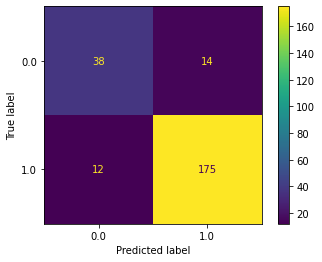


XGBoost Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.76      0.73      0.75        52
         1.0       0.93      0.94      0.93       187

    accuracy                           0.89       239
   macro avg       0.84      0.83      0.84       239
weighted avg       0.89      0.89      0.89       239


Accuracy: 0.891

XGBoost Train/Test/CV Scoring


,train,test,cv
recall,0.977,0.833,0.958
precision,0.978,0.843,0.916
f1,0.977,0.838,0.935


In [33]:
xgb = XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='error', gamma=5,
                   colsample_bytree=0.45, learning_rate=0.05, reg_lambda=1, max_depth=15,
                   min_child_weight=0, reg_alpha=1, scale_pos_weight=2, subsample=0.9)

xgb.fit(x_train, y_train)
xgb_predictions = xgb.predict(x_test)
xgb_predictions_train = xgb.predict(x_train)

xgb_matrix = metrics.confusion_matrix(y_test,xgb_predictions)

plot_confusion_matrix(xgb, x_test, y_test)  
plt.show()

class_report_xgb = classification_report(y_test, xgb_predictions)
print("\nXGBoost Confusion Matrix\n",class_report_xgb)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,xgb_predictions),3))

print('\nXGBoost Train/Test/CV Scoring')
fitting_score(xgb_predictions_train, xgb_predictions, xgb)

## Model result: Gradient Boosting yields the best CV f1 score

## 6. Run statistical analysis on each features. 
In this section, we are using logit and probit models to get a read on how much each independent variable affects the likelihood of licensing

In [32]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(x_train,y_train)
logreg

print("Training set score: {:.3f}".format(logreg.score(x_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(x_test,y_test)))

import statsmodels.api as sm
logit_model=sm.Logit(y,X)

#Use method = 'bfgs' because default Hessian method starts with a bad starting value and reaches max iterations
result=logit_model.fit(method = 'bfgs')
print(result.summary())

Training set score: 0.810
Test set score: 0.770
         Current function value: 0.363396
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
                           Logit Regression Results                           
Dep. Variable:         License_Status   No. Observations:                 1192
Model:                          Logit   Df Residuals:                     1153
Method:                           MLE   Df Model:                           38
Date:                Tue, 02 Aug 2022   Pseudo R-squ.:                  0.3086
Time:                        12:01:43   Log-Likelihood:                -433.17
converged:                      False   LL-Null:                       -626.50
Covariance Type:            nonrobust   LLR p-value:                 2.665e-59
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
